In [177]:
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

In [178]:
##helper methods
def simple_rmse(model, X, Y):
    y_pred = model.predict(X)
    rmse = -np.sqrt(mean_squared_error(y_pred, Y))
    return rmse

def rmse_cv(model, X_train, y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def plot_it(model):
    model.fit(tp, tpl)
    preds = model.predict(dp)
    
    deltas = preds-dpl
    print "mean: %3.4f" %np.mean(deltas)
    print "standard deviation: %3.4f" %np.std(deltas)
    
    plt.scatter(dpl,preds)
    plt.xlim((10,14.0))
    plt.ylim((10,14.0))
    plt.plot(range(10,15), range(10,15));
    
def plot_pca(model, n):
    scores = []
    pca = PCA(n)
    pca_train = pca.fit_transform(train_split)
    pca_dev = pca.transform(dev)
    for i in range(n):
        model.fit(pca_train[:,0:i+1], train_split_labels)
        scores.append(-simple_rmse(model, pca_dev[:,0:i+1], dev_labels))
    
    plt.scatter(range(1,n+1),scores)
    plt.show()

In [179]:
##read in data
train = pd.read_csv('data/train_fe.csv',delimiter=',',header=0)
train = train.drop( ["SalePrice"], axis=1 )
train = train.drop(['Unnamed: 0'],axis=1)
train_split, dev, train_split_labels, dev_labels = train_test_split(train,train_labels, test_size = .5, random_state=207)
test = pd.read_csv('data/test_fe.csv',delimiter=',',header=0)
test = test.drop(['Unnamed: 0'],axis=1)

##get linear predictions
linear_dev_preds = pd.read_csv('data/linear_out_dev.csv',delimiter=',',header=0)
preds_labels = linear_dev_preds["Actual"].copy()
linear_dev_preds = linear_dev_preds.drop(['Actual'],axis=1)
linear_dev_preds = linear_dev_preds.drop(['Unnamed: 0'],axis=1)
linear_test_preds = pd.read_csv('data/linear_out_test.csv',delimiter=',',header=0)
linear_test_preds = linear_test_preds.drop(['Unnamed: 0'],axis=1)

##get nonlinear predictions
nl_dev_preds = pd.read_csv('data/nl_out_dev.csv',delimiter=',',header=0)
nl_dev_preds = nl_dev_preds.drop(['Actual'],axis=1)
nl_test_preds = pd.read_csv('data/nl_out_test.csv',delimiter=',',header=0)

# ##combine
# train_x = pd.concat([nl_dev_preds, linear_dev_preds], axis=1)
# test_x = pd.concat([nl_test_preds, linear_test_preds], axis=1)
# print train_x.shape
# print test_x.shape

train_x = nl_dev_preds
train_y = preds_labels
test_x = nl_test_preds

##split linear predictions
tp, dp, tpl, dpl = train_test_split(train_x,preds_labels, test_size = .8, random_state=207)

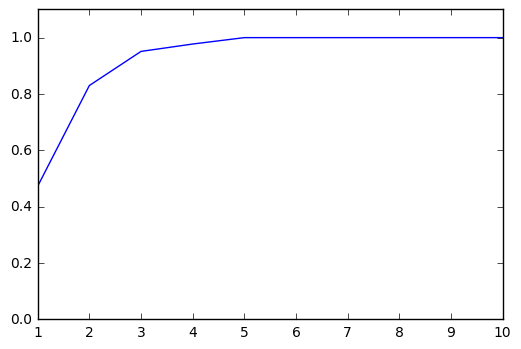

In [180]:
##pca
pca_test = PCA(10)
pca_x = pca_test.fit_transform(dev)
pca_x2 = pca_test.transform(test)

var = []
for a in range(10):
    var.append(np.sum(pca_test.explained_variance_ratio_[:a+1]))
    
plt.plot(range(1,11), var)
plt.ylim((0,1.1));

In [181]:
##combine pca and predictions
pca_x = pd.DataFrame(pca_x)
pca_x2 = pd.DataFrame(pca_x2)
comb = pd.concat([train_x, pca_x], axis=1)
comb_test = pd.concat([test_x, pca_x2], axis=1)
comb2 = pd.concat([train_x, dev.reset_index()], axis=1)
comb2 = comb2.drop("index", axis=1)
comb2_test = pd.concat([test_x, test], axis=1)

In [182]:
##build ensemble model
ensemble = GBR()
##GradientBoostingRegressor
est = [200,300,400, 500, 1000, 1500]
md = [1,2,3]
lr = [.001,.01, .1]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["ls", "lad", "huber"]}
gs3 = GridSearchCV(ensemble, gbr_params, scoring = simple_rmse)
gs3.fit(train_x,train_y)
end = time.time()
print end-start
print gs3.best_estimator_
print gs3.best_score_
print gs3.best_params_

# f, axarr = plt.subplots(len(lr))
# for b,val2 in enumerate(lr):
#     for a,val in enumerate(md):
#         axarr[b].plot(est,-gs3.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
#         axarr[b].legend()
#         axarr[b].set_ylim((0.1,.4))
        
# f.set_figheight(5 * len(lr))
# f.set_figwidth(5)
# f.show;

200.700999975
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.125942304193
{'max_features': 'auto', 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 3}
({'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.001, 'n_estimators': 200, 'max_depth': 1}, {'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.001, 'n_estimators': 300, 'max_depth': 1}, {'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.001, 'n_estimators': 400, 'max_depth': 1}, {'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.001, 'n_estimators': 500, 'max_depth': 1}, {'max_features': 'auto', 'loss':

In [183]:
# ##best version
# ls_gbr_best = GBR(n_estimators =gs3.best_params_['n_estimators'],max_features =gs3.best_params_['max_features'], max_depth =gs3.best_params_['max_depth'], learning_rate =gs3.best_params_['learning_rate'], loss=gs3.best_params_['loss'])
# plot_it(ls_gbr_best)

In [184]:
##build ensemble model
ensemble = GBR()
##GradientBoostingRegressor
est = [200,300,400, 500, 1000, 1500]
md = [1,2,3]
lr = [.001,.01, .1]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["ls", "lad", "huber"]}
gs3b = GridSearchCV(ensemble, gbr_params, scoring = simple_rmse)
gs3b.fit(comb,train_y)
end = time.time()
print end-start
print gs3b.best_estimator_
print gs3b.best_score_
print gs3b.best_params_

# f, axarr = plt.subplots(len(lr))
# for b,val2 in enumerate(lr):
#     for a,val in enumerate(md):
#         axarr[b].plot(est,-gs3b.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
#         axarr[b].legend()
#         axarr[b].set_ylim((0.1,.4))
        
# f.set_figheight(5 * len(lr))
# f.set_figwidth(5)
# f.show;

288.59100008
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.126385604469
{'max_features': 'auto', 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 3}


In [185]:
# ##best version
# ls_gbr_best2 = GBR(n_estimators =gs3b.best_params_['n_estimators'],max_features =gs3b.best_params_['max_features'], max_depth =gs3b.best_params_['max_depth'], learning_rate =gs3b.best_params_['learning_rate'], loss=gs3b.best_params_['loss'])
# plot_it(ls_gbr_best2)

In [186]:
##build ensemble model
ensemble = GBR()
##GradientBoostingRegressor
est = [200,300,400, 500, 1000, 1500]
md = [1,2,3]
lr = [.001,.01, .1]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["ls", "lad", "huber"]}
gs3c = GridSearchCV(ensemble, gbr_params, scoring = simple_rmse)
gs3c.fit(comb2,train_y)
end = time.time()
print end-start
print gs3.best_estimator_
print gs3.best_score_
print gs3.best_params_


# f, axarr = plt.subplots(len(lr))
# for b,val2 in enumerate(lr):
#     for a,val in enumerate(md):
#         axarr[b].plot(est,-gs3.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
#         axarr[b].legend()
#         axarr[b].set_ylim((0.1,.4))
        
# f.set_figheight(5 * len(lr))
# f.set_figwidth(5)
# f.show;

922.582000017
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.125942304193
{'max_features': 'auto', 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 3}


In [187]:
# ##best version
# ls_gbr_best3 = GBR(n_estimators =gs3c.best_params_['n_estimators'],max_features =gs3c.best_params_['max_features'], max_depth =gs3c.best_params_['max_depth'], learning_rate =gs3c.best_params_['learning_rate'], loss=gs3c.best_params_['loss'])
# plot_it(ls_gbr_best3)

In [190]:
##output results
ls_gbr_best.fit(train_x, train_y)
ls_gbr_best2.fit(comb, train_y)
ls_gbr_best3.fit(comb2, train_y)

preds1 = np.exp(ls_gbr_best.predict(test_x))
preds2 = np.exp(ls_gbr_best2.predict(comb_test))
preds3 = np.exp(ls_gbr_best3.predict(comb2_test))

allpreds = {"PredsOnly": preds1,
           "PredsPCA": preds2,
           "PredsTest": preds3}

preds_array = np.array([preds1,preds2,preds3])
means = np.mean(preds_array, axis=0)
price = {"SalePrice": means}
preds = pd.DataFrame(data = price)
preds2 = pd.DataFrame(data =allpreds)
preds.to_csv('data/final_preds.csv')
preds2.to_csv('data/final_preds_seperate.csv')